In [16]:
#load packages
import pandas as pd
import json
import sklearn
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import patches, text, patheffects
import cv2

In [8]:
#load data
path = r"/Users/rowanconverse/Library/CloudStorage/OneDrive-UniversityofNewMexico/CV4Ecology/Prototyping/Data/Labels/coco/zooupdate1_coco.json"
with open(path) as f:
  cocozoo = json.load(f)

dgc = []
for ann in cocozoo:
    if ann['category'] == 'Other Bird' or ann['category'] == 'Seagull':
        continue
    else:
        dgc.append(ann)
len(dgc)

1143780

In [7]:
testimg = "BDA_12c_20181113_1_00425_03_07.png"
snip = []
for img in dgc:
    if img["filename"] == testimg:
        snip.append(img)
    else:
        continue

len(snip)

155

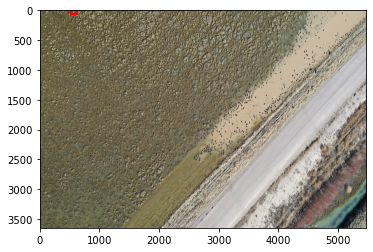

In [26]:
#Display bounding boxes on image for verification

#img = mpimg.imread('/Users/rowanconverse/Library/CloudStorage/OneDrive-UniversityofNewMexico/CV4Ecology/Prototyping/Data/Imagery/SB597/subset/BDA_12c_20181113_1_00425.JPG')
#imgplot = plt.imshow(img)

fig, ax = plt.subplots()

img = cv2.imread(str('/Users/rowanconverse/Library/CloudStorage/OneDrive-UniversityofNewMexico/CV4Ecology/Prototyping/Data/Imagery/SB597/subset/BDA_12c_20181113_1_00425.JPG'))
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
ax.imshow(img)

#def get_target_ds(name, df):
##  rows = df[df["name"] == name[:-4]]
#  return rows["class"].values, rows[bboxes_cols].valuesbboxes_cols = ["center_x", "center_y", "width", "height"]

#labels, boxes = get_target_ds(path_img.name, train_df)

x = snip[0]["bbox"][0]
y = snip[0]["bbox"][1]
w = snip[0]["bbox"][2]
h = snip[0]["bbox"][3]

ax.add_patch(patches.Rectangle((x,y),w,h, fill=False, edgecolor='red', lw=2))


In [25]:
#Cluster BBoxes using DBSCAN
snip[0]["bbox"][0]

530.1105346679688

In [ ]:
#Calculate median coordinates of xy and width/height 

In [ ]:
#Take plurality vote of classification label